In [1]:
# Import all necessary
import numpy as np
import matplotlib.pyplot as plt
import cv2 as cv
#import seaborn as sns
import os
import re
import requests
import csv

In [2]:
from sklearn.metrics import confusion_matrix,  multilabel_confusion_matrix
from sklearn.preprocessing import MultiLabelBinarizer
from sklearn.model_selection import train_test_split
from keras.models import Sequential
from keras.layers import Conv2D, Dense, Flatten, MaxPooling2D
from keras.layers import BatchNormalization, Activation, Dropout
from keras.preprocessing.image import ImageDataGenerator
from keras.callbacks import ModelCheckpoint

Using TensorFlow backend.


# Creating train and test datasets
The dataset already divided  to train and test dataset, but in that case it will be easier to load all data in one array and then split it to train, validation and test datasets.

In [3]:
import pandas as pd
df = pd.read_csv('./UECFOOD100/label30.csv')
df

,image_id,boxes,labels,ingredients,calories,protein,fat,carbohydrates
0,./UECFOOD100\1\1.jpg,"[['0', '143', '370', '486']]",1,['rice'],130,2.7,0.3,2.7
1,./UECFOOD100\1\2.jpg,"[['20', '208', '582', '559']]",1,['rice'],130,2.7,0.3,2.7
2,./UECFOOD100\1\3.jpg,"[['2', '110', '243', '410']]",1,['rice'],130,2.7,0.3,2.7
3,./UECFOOD100\1\4.jpg,"[['0', '237', '286', '536']]",1,['rice'],130,2.7,0.3,2.7
4,./UECFOOD100\1\5.jpg,"[['8', '28', '761', '585']]",1,['rice'],130,2.7,0.3,2.7
...,...,...,...,...,...,...,...,...
3524,./UECFOOD100\87\16697.jpg,"[['390', '102', '640', '353']]",87,"['green', 'salad']",50,2.0,0.0,2.0
3525,./UECFOOD100\87\16705.jpg,"[['309', '126', '634', '434']]",87,"['green', 'salad']",50,2.0,0.0,2.0
3526,./UECFOOD100\87\16706.jpg,"[['86', '50', '314', '208']]",87,"['green', 'salad']",50,2.0,0.0,2.0
3527,./UECFOOD100\87\16711.jpg,"[['122', '61', '536', '454']]",87,"['green', 'salad']",50,2.0,0.0,2.0


In [4]:
df['image_id'] = df['image_id'].apply(lambda x : x.replace("\\", "/"))
df

,image_id,boxes,labels,ingredients,calories,protein,fat,carbohydrates
0,./UECFOOD100/1/1.jpg,"[['0', '143', '370', '486']]",1,['rice'],130,2.7,0.3,2.7
1,./UECFOOD100/1/2.jpg,"[['20', '208', '582', '559']]",1,['rice'],130,2.7,0.3,2.7
2,./UECFOOD100/1/3.jpg,"[['2', '110', '243', '410']]",1,['rice'],130,2.7,0.3,2.7
3,./UECFOOD100/1/4.jpg,"[['0', '237', '286', '536']]",1,['rice'],130,2.7,0.3,2.7
4,./UECFOOD100/1/5.jpg,"[['8', '28', '761', '585']]",1,['rice'],130,2.7,0.3,2.7
...,...,...,...,...,...,...,...,...
3524,./UECFOOD100/87/16697.jpg,"[['390', '102', '640', '353']]",87,"['green', 'salad']",50,2.0,0.0,2.0
3525,./UECFOOD100/87/16705.jpg,"[['309', '126', '634', '434']]",87,"['green', 'salad']",50,2.0,0.0,2.0
3526,./UECFOOD100/87/16706.jpg,"[['86', '50', '314', '208']]",87,"['green', 'salad']",50,2.0,0.0,2.0
3527,./UECFOOD100/87/16711.jpg,"[['122', '61', '536', '454']]",87,"['green', 'salad']",50,2.0,0.0,2.0


In [5]:
dataframe = df[['image_id', 'ingredients']]
dataframe

,image_id,ingredients
0,./UECFOOD100/1/1.jpg,['rice']
1,./UECFOOD100/1/2.jpg,['rice']
2,./UECFOOD100/1/3.jpg,['rice']
3,./UECFOOD100/1/4.jpg,['rice']
4,./UECFOOD100/1/5.jpg,['rice']
...,...,...
3524,./UECFOOD100/87/16697.jpg,"['green', 'salad']"
3525,./UECFOOD100/87/16705.jpg,"['green', 'salad']"
3526,./UECFOOD100/87/16706.jpg,"['green', 'salad']"
3527,./UECFOOD100/87/16711.jpg,"['green', 'salad']"


In [6]:
dataframe.to_csv('newlabel.csv', header=False, index=False)

In [7]:
# read csv file with image names and labels
with open('newlabel.csv') as labels_csv:
    reader = csv.reader(labels_csv, delimiter=',')
    img_labels = [img for img in reader]
    
img_labels

[['./UECFOOD100/1/1.jpg', "['rice']"],
 ['./UECFOOD100/1/2.jpg', "['rice']"],
 ['./UECFOOD100/1/3.jpg', "['rice']"],
 ['./UECFOOD100/1/4.jpg', "['rice']"],
 ['./UECFOOD100/1/5.jpg', "['rice']"],
 ['./UECFOOD100/1/6.jpg', "['rice']"],
 ['./UECFOOD100/1/7.jpg', "['rice']"],
 ['./UECFOOD100/1/8.jpg', "['rice']"],
 ['./UECFOOD100/1/9.jpg', "['rice']"],
 ['./UECFOOD100/1/10.jpg', "['rice']"],
 ['./UECFOOD100/1/12.jpg', "['rice']"],
 ['./UECFOOD100/1/13.jpg', "['rice']"],
 ['./UECFOOD100/1/14.jpg', "['rice']"],
 ['./UECFOOD100/1/17.jpg', "['rice']"],
 ['./UECFOOD100/1/18.jpg', "['rice']"],
 ['./UECFOOD100/1/19.jpg', "['rice']"],
 ['./UECFOOD100/1/20.jpg', "['rice']"],
 ['./UECFOOD100/1/21.jpg', "['rice']"],
 ['./UECFOOD100/1/22.jpg', "['rice']"],
 ['./UECFOOD100/1/23.jpg', "['rice']"],
 ['./UECFOOD100/1/24.jpg', "['rice']"],
 ['./UECFOOD100/1/25.jpg', "['rice']"],
 ['./UECFOOD100/1/26.jpg', "['rice']"],
 ['./UECFOOD100/1/27.jpg', "['rice']"],
 ['./UECFOOD100/1/28.jpg', "['rice']"],
 ['./UECF

In [8]:
# extract all labels and create class list
full_labels = []
for img in img_labels:
    for element in img[1:]:
        element = element.replace("[", "")
        element = element.replace("]", "")
        element = element.replace("'", "")
        element = element.replace(" ", "")
        item = element.split(',')
        full_labels.extend(item)

class_list = sorted(list(set(full_labels)))
class_list

['beef',
 'bowl',
 'bread',
 'chicken',
 'curry',
 'eels',
 'fried',
 'green',
 'hambarg',
 'hamburger',
 'noodle',
 'pilaf',
 'potato',
 'raisin',
 'rice',
 'roast',
 'salad',
 'sandwiches',
 'steak',
 'tempura',
 'tensin',
 'udon']

In [9]:
len(class_list)

22

In [10]:
# create and populate label vectors
Y = np.zeros([len(img_labels), len(class_list)], dtype=np.float32)
for i, img in enumerate(img_labels):
    for element in img[1:]:
        element = element.replace("[", "")
        element = element.replace("]", "")
        element = element.replace("'", "")
        element = element.replace(" ", "")
        item = element.split(',')
        for l in item:
            Y[i][class_list.index(l)] = 1
            
Y.shape   

(3529, 22)

In [11]:
# delete the labels that have less labeled examples than the threshold allows
delete_ind = []
delete_name = []
labeled_thresh = 10
if labeled_thresh is not None:
    for i, col in enumerate(Y.sum(0)):
        if col < labeled_thresh:
            delete_ind.append(i)
            delete_name.append(class_list[i])
    Y = np.delete(Y, delete_ind, 1)
    for i in sorted(delete_ind, reverse=True):
        del class_list[i]
        
Y.shape

(3529, 22)

In [12]:
# load image data (unless their labels have all been deleted)
input_shape = (96, 96, 3)
X = []
file_names = []
delete_ind = []
for i, img in enumerate(img_labels):
    if Y[i].sum() != 0:
        image = cv.imread(img[0])
        # Resizing image
        image = cv.resize(image, (input_shape[1], input_shape[0]))
        X.append(image)
        file_names.append(img[0])
    else:
        delete_ind.append(i)
Y = np.delete(Y, delete_ind, 0)
X

[array([[[ 20,  19,  18],
         [ 11,  18,  15],
         [ 15,  21,  20],
         ...,
         [ 57,  71,  66],
         [ 53,  64,  58],
         [ 76,  92,  83]],
 
        [[ 17,  21,  20],
         [ 14,  18,  19],
         [ 13,  16,  20],
         ...,
         [ 68,  81,  75],
         [ 54,  70,  63],
         [ 59,  71,  70]],
 
        [[ 17,  22,  21],
         [ 14,  20,  19],
         [ 12,  18,  18],
         ...,
         [ 70,  81,  79],
         [ 56,  75,  66],
         [ 57,  73,  66]],
 
        ...,
 
        [[121, 134, 120],
         [115, 121, 104],
         [  5,   7,   4],
         ...,
         [ 90, 135, 162],
         [ 65, 112, 136],
         [ 97, 135, 160]],
 
        [[121, 130, 123],
         [ 98,  97,  83],
         [ 11,   7,   6],
         ...,
         [150, 195, 204],
         [ 73, 129, 150],
         [169, 216, 226]],
 
        [[122, 129, 117],
         [ 42,  40,  30],
         [  9,   6,   4],
         ...,
         [204, 235, 230],
  

In [13]:
len(X)

3529

In [14]:
# Convert X to numpy array and scale values between 0 and 1
X = np.array(X) / 255.0
X.shape

(3529, 96, 96, 3)

In [16]:
Y = np.array(Y)
Y[100]

array([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0.,
       0., 0., 0., 0., 0.], dtype=float32)

In [21]:
# test_x and test_y will be used for final predictions
x, test_x, y, test_y = train_test_split(X, Y, test_size = 0.1, stratify = Y, shuffle = True, random_state = 1)
# train_x, val_x, train_y, val_y will be used to train model and validate results during training
train_x, val_x, train_y, val_y = train_test_split(x, y, test_size = 0.2, stratify = y, shuffle = True, random_state = 1)

print(x.shape, test_x.shape, y.shape, test_y.shape)
print(train_x.shape, val_x.shape, train_y.shape, val_y.shape)

# I'll use ImageDataGenerator to apply random transformations to images
datagen = ImageDataGenerator(rotation_range = 45,
                            width_shift_range = 0.1,
                            height_shift_range = 0.1,
                            zoom_range = 0.2,
                            horizontal_flip = True,
                            validation_split = 0.2)

(3176, 96, 96, 3) (353, 96, 96, 3) (3176, 22) (353, 22)
(2540, 96, 96, 3) (636, 96, 96, 3) (2540, 22) (636, 22)


# Model creation and training

In [21]:
# Creating model architecture
model = Sequential()
model.add(Conv2D(32, 3, padding = 'same', input_shape = input_shape, kernel_initializer = 'he_normal', activation = 'relu'))
model.add(BatchNormalization())
model.add(MaxPooling2D(3))
model.add(Dropout(0.25))

model.add(Conv2D(64, 3, padding = 'same', kernel_initializer = 'he_normal', activation = 'relu'))
model.add(BatchNormalization())
model.add(Conv2D(64, 3, padding = 'same', kernel_initializer = 'he_normal', activation = 'relu'))
model.add(BatchNormalization())
model.add(MaxPooling2D())
model.add(Dropout(0.25))

model.add(Conv2D(128, 3, padding = 'same', kernel_initializer = 'he_normal', activation = 'relu'))
model.add(BatchNormalization())
model.add(Conv2D(128, 2, padding = 'same', kernel_initializer = 'he_normal', activation = 'relu'))
model.add(BatchNormalization())
model.add(MaxPooling2D())
model.add(Dropout(0.25))

model.add(Flatten())
model.add(Dense(1024, activation = 'relu', kernel_initializer = 'he_normal'))
model.add(BatchNormalization())
model.add(Dropout(0.5))

# model.summary()

model.add(Dense(Y.shape[1], activation = 'sigmoid'))

# Checkpoint to save best model
checkpoint = ModelCheckpoint('best_model.hdf5', save_best_only = True, monitor = 'val_loss', verbose = 1)

model.compile(optimizer = 'adam', loss = 'binary_crossentropy', metrics = ['accuracy'])

#history = model.fit_generator(datagen.flow(train_x, train_y, batch_size = 64),
#                             validation_data = (val_x, val_y), epochs = 30, verbose = 1, callbacks = [checkpoint])

In [24]:
model.load_weights('best_model.hdf5')

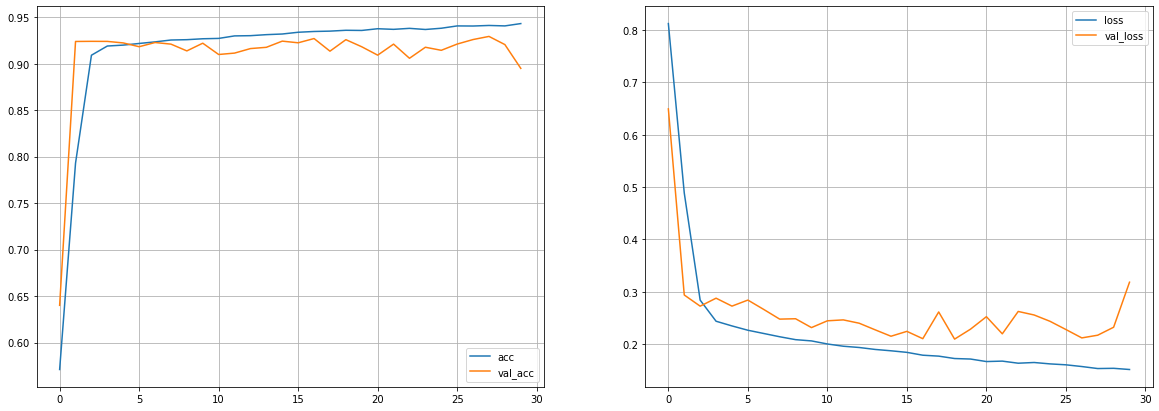

In [25]:
# Plot training results
H = history.history
fig = plt.figure(figsize = (20, 7))
plt.subplot(121)
plt.plot(H['accuracy'], label = 'acc')
plt.plot(H['val_accuracy'], label = 'val_acc')
plt.grid()
plt.legend()

plt.subplot(122)
plt.plot(H['loss'], label = 'loss')
plt.plot(H['val_loss'], label = 'val_loss')
plt.grid()
plt.legend()

In [26]:
from PIL import Image
fig = plt.figure(figsize = (15, 15))

<Figure size 1080x1080 with 0 Axes>

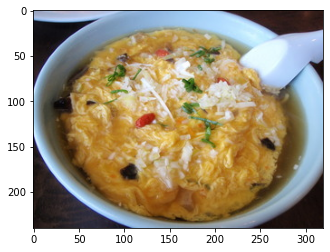

In [54]:
# Reading image, convert it to np array and decode
image = cv.imread("./UECFOOD100/25/2392.jpg")
image = cv.cvtColor(image, cv.COLOR_BGR2RGB)
plt.imshow(image)
resized = cv.resize(image, (input_shape[1], input_shape[0]))
resized = (resized / 255.0).reshape(-1, input_shape[1], input_shape[0], input_shape[2])

In [55]:
# Predict results
preds = model.predict(resized)
preds

array([[0.20370206, 0.07366087, 0.22601247, 0.10475184, 0.27267322,
        0.06897368, 0.08525503, 0.14026374, 0.12229666, 0.05188573,
        0.07928921, 0.09048245, 0.22015032, 0.10669596, 0.2677553 ,
        0.06575572, 0.37637648, 0.22897147, 0.09033394, 0.07584708,
        0.10526624, 0.09254573]], dtype=float32)

In [56]:
preds = np.where(preds < 0.3, 0, 1)
preds

array([[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0]])

In [57]:
for i in range(Y.shape[1]):
    if preds[0][i] == 1:
        print(class_list[i])

salad


In [22]:
train_X, test_x, train_y, test_y = train_test_split(X, Y, test_size = 0.2, shuffle = True, random_state = 1)

In [23]:
history = model.fit(train_X, train_y)

Epoch 1/1
2823/2823 [==============================] - 69s 25ms/step - loss: 0.6316 - accuracy: 0.6941


In [30]:
model.save('best.h5')